In [1]:
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
from sklearn.metrics import mean_squared_error
from itertools import combinations
import numpy as np
from ucimlrepo import fetch_ucirepo

## Data preparation and normalization

In [ ]:
adult = fetch_ucirepo(id=2)
X_original = adult.data.features
y_original = adult.data.targets
X_age = np.array(X_original)[:20000,0]
X_wh = np.array(X_original)[:20000,12]
X = np.column_stack((X_age, X_wh))
y = np.array(y_original)[:20000]

y_cleaned = np.array([label[0].replace('.', '') for label in y])
encoder = LabelEncoder()
y = encoder.fit_transform(y_cleaned)
X = pd.DataFrame(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y = 2*y - 1

# Preparing selected features hello
X_age = np.array(X_original)[:20000,0]  # age
X_edu = np.array(X_original)[:20000,4]  # education-num
X_sex = np.array(X_original)[:20000,9]  # sex
X_hours = np.array(X_original)[:20000,12]  # hours-per-week
X_marital = np.array(X_original)[:20000,5]  # marital-status
X_selected = np.column_stack((X_age, X_edu, X_sex, X_hours, X_marital))
X_selected = pd.DataFrame(X_selected, columns=['age', 'education-num', 'sex', 'hours-per-week', 'marital-status'])

label_encoder = LabelEncoder()
X_selected['sex'] = label_encoder.fit_transform(X_selected['sex'])
X_selected['marital-status'] = label_encoder.fit_transform(X_selected['marital-status'])

scaler = StandardScaler()
X_selected_scaled = scaler.fit_transform(X_selected)

X_train, X_test, y_train, y_test = train_test_split(X_selected_scaled, y, test_size=0.3, random_state=42)



## Part 1: Linear Regression

Linear Regression results:
Coefficients: [ 0.15150536  0.2488241   0.13063162  0.10788532 -0.07952674]
Intercept: -0.5233440244189612
Score: 0.21678827079590157


Text(0.5, 1.0, 'Feature Importance in Linear Regression')

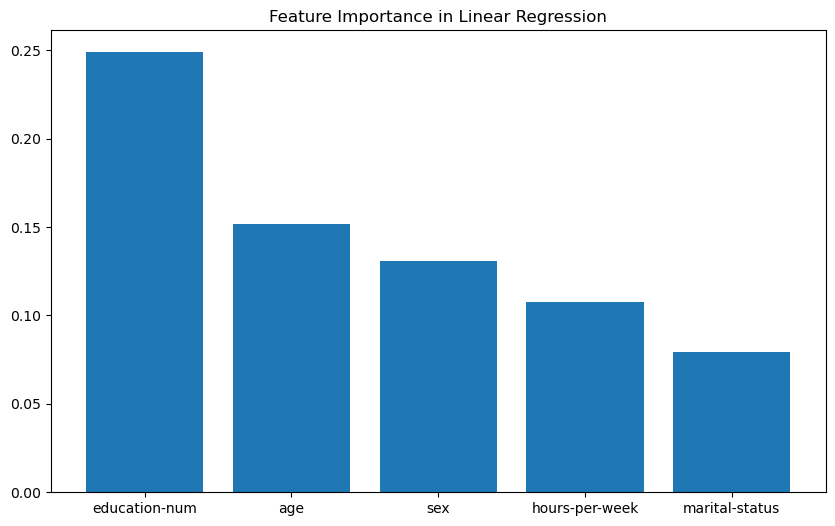

In [ ]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
print("Linear Regression results:")
print("Coefficients:", lr_model.coef_)
print("Intercept:", lr_model.intercept_)
print("Score:", lr_model.score(X_test, y_test))

plt.figure(figsize=(10, 6))
feature_importance = pd.DataFrame({
    'feature': ['age', 'education-num', 'sex', 'hours-per-week', 'marital-status'],
    'importance': abs(lr_model.coef_)
})
feature_importance = feature_importance.sort_values('importance', ascending=False)
plt.bar(feature_importance['feature'], feature_importance['importance'])
plt.title('Feature Importance in Linear Regression')


From the bar chart we found the relative impact of each feature on income prediction in our linear regression model is Education-num > Age > Sex > Hours-per-week > Marital-status

### MSE Analysis

Validation MSE: 0.5698


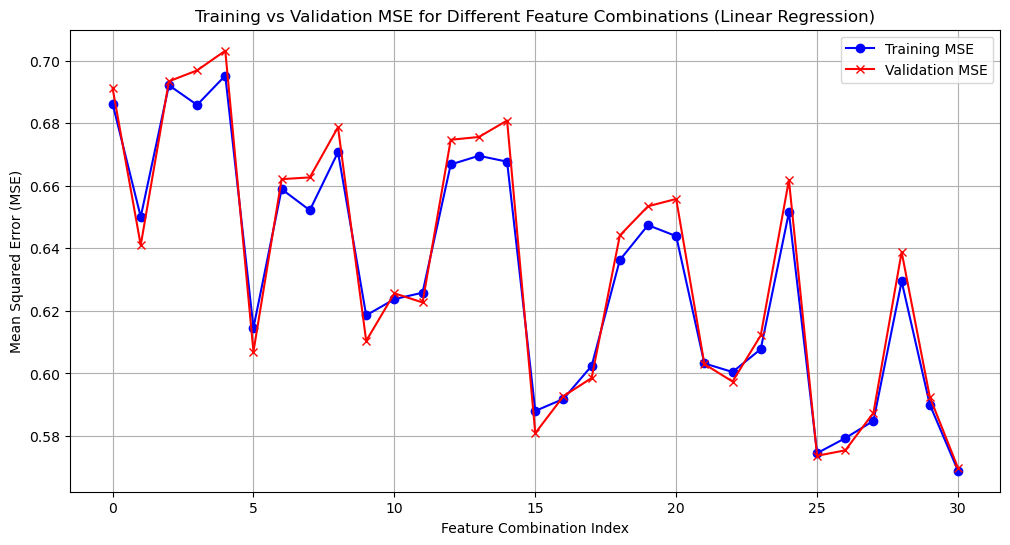

In [ ]:
feature_combinations = []
all_features = ['age', 'education-num', 'sex', 'hours-per-week', 'marital-status']
for r in range(1, len(all_features) + 1):
    feature_combinations.extend(combinations(range(X_selected_scaled.shape[1]), r))

results_lr = []

for combo in feature_combinations:
    X_train_combo = X_train[:, list(combo)]
    X_test_combo = X_test[:, list(combo)]
    
    lr = LinearRegression()
    lr.fit(X_train_combo, y_train)
    
    y_train_pred = lr.predict(X_train_combo)
    y_val_pred = lr.predict(X_test_combo)
    
    train_mse = mean_squared_error(y_train, y_train_pred)
    val_mse = mean_squared_error(y_test, y_val_pred)
    
    results_lr.append({
        'features': [all_features[i] for i in combo],
        'train_mse': train_mse,
        'val_mse': val_mse
    })

results_lr_df = pd.DataFrame(results_lr)

plt.figure(figsize=(12, 6))
plt.plot(range(len(results_lr_df)), results_lr_df['train_mse'], color='blue', label='Training MSE', marker='o')
plt.plot(range(len(results_lr_df)), results_lr_df['val_mse'], color='red', label='Validation MSE', marker='x')

plt.legend()
plt.xlabel("Feature Combination Index")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Training vs Validation MSE for Different Feature Combinations (Linear Regression)")
plt.grid(True)

best_lr_idx = results_lr_df['val_mse'].idxmin()
best_lr_combo = results_lr_df.iloc[best_lr_idx]
print(f"Validation MSE: {best_lr_combo['val_mse']:.4f}")

## Part 2: KNN Classification

Testing K = 1
Cross-Validation Accuracy for K = 1: 0.7684
Test Accuracy: 0.7741666666666667
Classification Report:
              precision    recall  f1-score   support

          -1       0.85      0.85      0.85      4566
           1       0.53      0.53      0.53      1434

    accuracy                           0.77      6000
   macro avg       0.69      0.69      0.69      6000
weighted avg       0.78      0.77      0.77      6000

Testing K = 3
Cross-Validation Accuracy for K = 3: 0.7917
Test Accuracy: 0.8081666666666667
Classification Report:
              precision    recall  f1-score   support

          -1       0.86      0.89      0.88      4566
           1       0.61      0.56      0.58      1434

    accuracy                           0.81      6000
   macro avg       0.74      0.72      0.73      6000
weighted avg       0.80      0.81      0.81      6000

Testing K = 5
Cross-Validation Accuracy for K = 5: 0.8072
Test Accuracy: 0.8151666666666667
Classification Report:
 

Text(0.02, 0.98, 'X-axis: Age (scaled)\nY-axis: Education (scaled)')

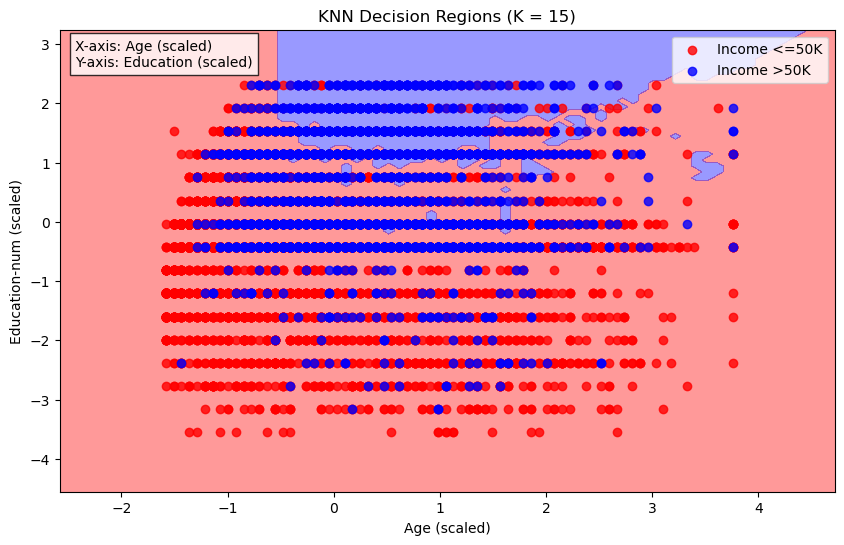

In [ ]:
k_values = [1, 3, 5, 7, 10, 15]
best_k = None
best_accuracy = 0

for k in k_values:
    print(f"Testing K = {k}")
    knn_model = KNeighborsClassifier(n_neighbors=k)
    cv_scores = cross_val_score(knn_model, X_train, y_train, cv=5, scoring='accuracy')
    mean_cv_accuracy = cv_scores.mean()
    print(f"Cross-Validation Accuracy for K = {k}: {mean_cv_accuracy:.4f}")
    knn_model.fit(X_train, y_train)
    knn_pred = knn_model.predict(X_test)
    accuracy = accuracy_score(y_test, knn_pred)
    print("Test Accuracy:", accuracy)
    print("Classification Report:")
    print(classification_report(y_test, knn_pred))

    if mean_cv_accuracy > best_accuracy:
        best_k = k
        best_accuracy = mean_cv_accuracy

print(f"Best K: {best_k} with Cross-Validation Accuracy: {best_accuracy:.4f}")
print(f"Visualizing Decision Regions for Best K = {best_k}")

X_subset = X_selected_scaled[:, [0, 1]]
X_train_subset, X_test_subset, y_train_subset, y_test_subset = train_test_split(
    X_subset, y, test_size=0.3, random_state=42
)

knn_subset = KNeighborsClassifier(n_neighbors=best_k)
knn_subset.fit(X_train_subset, y_train_subset)

x_min, x_max = X_subset[:, 0].min() - 1, X_subset[:, 0].max() + 1
y_min, y_max = X_subset[:, 1].min() - 1, X_subset[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

Z = knn_subset.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.4, levels=[-2, 0, 2], colors=['red', 'blue'])

mask_low = y_train_subset == -1
mask_high = y_train_subset == 1

plt.scatter(X_train_subset[mask_low, 0], X_train_subset[mask_low, 1], c='red', label='Income <=50K', alpha=0.8)
plt.scatter(X_train_subset[mask_high, 0], X_train_subset[mask_high, 1], c='blue', label='Income >50K', alpha=0.8)

plt.xlabel('Age (scaled)')
plt.ylabel('Education-num (scaled)')
plt.title(f"KNN Decision Regions (K = {best_k})")
plt.legend()
plt.text(0.02, 0.98, 'X-axis: Age (scaled)\nY-axis: Education (scaled)', 
         transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8),
         verticalalignment='top')


#### From diagram we can know:
Higher education levels tend to show more blue regions which has higher income
Middle aged individuals with higher education show strongest concentration of high income
Lower education levels predominantly show red regions whcih has lower income

### MSE analysis

Validation MSE: 0.7093


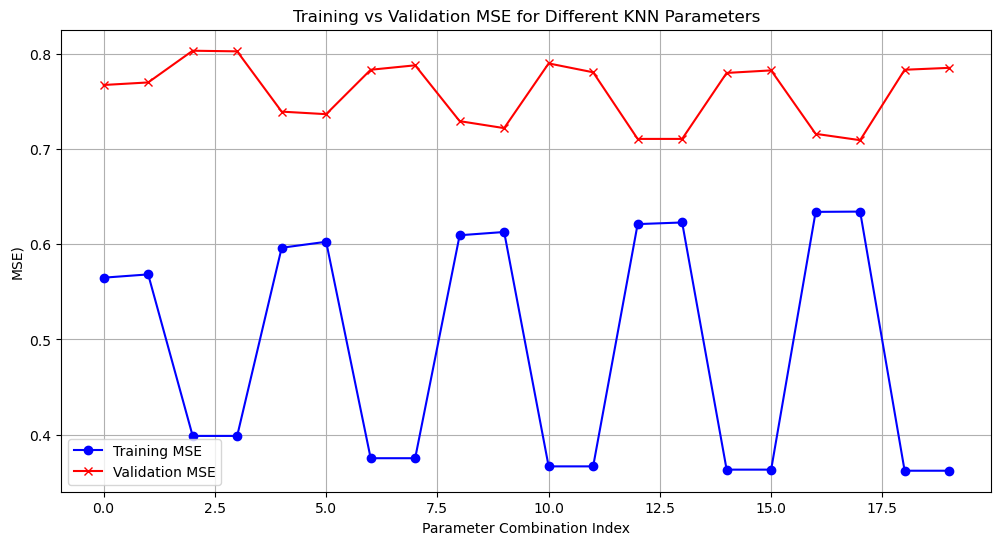

In [17]:
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
results_knn = []

for n_neighbors in param_grid_knn['n_neighbors']:
    for weights in param_grid_knn['weights']:
        for metric in param_grid_knn['metric']:
            knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, metric=metric)
            knn.fit(X_train, y_train)
            y_train_pred = knn.predict(X_train)
            y_val_pred = knn.predict(X_test)
            train_mse = mean_squared_error(y_train, y_train_pred)
            val_mse = mean_squared_error(y_test, y_val_pred)
            results_knn.append({
                'n_neighbors': n_neighbors,
                'weights': weights,
                'metric': metric,
                'train_mse': train_mse,
                'val_mse': val_mse
            })

results_knn_df = pd.DataFrame(results_knn)
plt.figure(figsize=(12, 6))
plt.plot(range(len(results_knn_df)), results_knn_df['train_mse'], color='blue', label='Training MSE', marker='o')
plt.plot(range(len(results_knn_df)), results_knn_df['val_mse'], color='red', label='Validation MSE', marker='x')
plt.legend()
plt.xlabel("Parameter Combination Index")
plt.ylabel("MSE)")
plt.title("Training vs Validation MSE for Different KNN Parameters")
plt.grid(True)

best_knn_idx = results_knn_df['val_mse'].idxmin()
best_knn_params = results_knn_df.iloc[best_knn_idx]
print(f"Validation MSE: {best_knn_params['val_mse']:.4f}")

## Conclusion

The Linear Regression model has a lower MSE of 0.5698, compared to 0.7093 for the K-Nearest Neighbors model. This indicates that Linear Regression was more effective in capturing the relationship between the selected features and income. The lower MSE suggests that the underlying relationship between the features and income is likely more linear, making a parametric approach like Linear Regression a better fit for this dataset. In contrast, KNN, being a non-parametric method, may struggle with the data distribution, especially if the decision boundary is not well-defined or if there is noise in the features.